In [2]:
import pandas as pd
from gurobi import *
import matplotlib.pyplot as plt

In [3]:
booking = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Booking_new.xlsx")
bd_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/BreakDownZones.xlsx")
dz_to_bd = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DistanceMatrixDropZoneToBreakDownZone.xlsx")
drop_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DropZones.xlsx")
bu_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='BU Zones')
bu_zones_workstations = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='WorkStation')
bu_zones_to_flight = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='FlightNumber-BUZone')
flight_default_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='DefaultProcessingTime')
flight_pre_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='Pre-ProcessingBufferTime')

In [4]:
booking.head()

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,Weight,Volume,BookingStatus,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC
0,020-77215633,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ACC,ZZ,False,DZ NRML-2,1,...,26.2,0.08,C,K,B,0.08,26.2,1,3,2018-10-25T05:15:00
1,020-77215515,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ADD,ZZ,False,DZ NRML-2,1,...,5.5,0.02,C,K,B,0.02,5.5,1,4,2018-10-27T13:45:00
2,020-84100306,2018-10-23,2018-10-23T06:10:00,NML,BBB,AGG,ZZ,False,DZ NML-1,1,...,2.6,0.01,C,K,B,0.01,2.6,1,7,2018-10-24T21:20:00
3,020-82036091,2018-10-23,2018-10-23T06:10:00,NRML,BBB,AII,ZZ,False,DZ NRML-2,1,...,1.7,0.01,C,K,B,0.01,1.7,1,9,2018-10-27T17:20:00
4,020-84368815,2018-10-23,2018-10-23T06:10:00,NRML,BBB,CCC,ZZ,False,DZ NRML-2,1,...,22.6,0.26,C,K,B,0.26,22.6,1,46,2018-10-24T23:00:00


In [5]:
bd_zones.head()

,Description,Name,NumberOfWorkstations,SequenceNumber,TransportationTimeToWH,TargetProcessName,HandlingTimePerULD
0,the biggest BD zone for normal ULDs,B BD NRML-1,33,1,00:30:00,NORMAL,00:24:00
1,the 2nd biggest BD zone for normal ULDs,B BD NRML-2,10,2,00:25:00,NORMAL,00:24:00
2,an animal BD zone,BD NML-1,4,3,00:40:00,ANIMAL,00:13:00
3,the biggest BD zone for ULDs that have to be c...,BD CLD-1,8,4,00:30:00,COOLED,00:17:00
4,a normal BD zone,BD NRML-1,5,5,00:30:00,NORMAL,00:20:00


In [6]:
dz_to_bd.head()

,BreakDownZoneName,DropZoneName,TransportDuration
0,B BD NRML-1,DZ NRML-1,00:25:00
1,B BD NRML-2,DZ NRML-1,00:11:00
2,BD NML-1,DZ NRML-1,00:19:00
3,BD CLD-1,DZ NRML-1,00:24:00
4,BD NRML-1,DZ NRML-1,00:05:00


In [7]:
drop_zones.head()

,Description,Name,NumberOfWorkstations,SequenceNumber,TargetProcessName
0,a drop zone for normal ULDs,DZ NRML-1,6,1,NORMAL
1,a drop zone for normal ULDs,DZ NRML-2,4,2,NORMAL
2,an animal drop zone,DZ NML-1,3,3,ANIMAL
3,a drop zone for ULDs that have to be cooled,DZ CLD-1,5,4,COOLED


In [8]:
bu_zones.head()

,Name,HandlingTimePerULD,TransportationTimeToWH
0,BU FT-1,00:24:00,00:50:00
1,BU FT-2,00:24:00,00:45:00
2,BU NML-1,00:13:00,00:40:00
3,BU CBD-1,00:17:00,00:50:00
4,BU NRML-1,00:20:00,00:50:00


In [9]:
bu_zones_workstations.head()

,WorkStationID,Name
0,FT-1-1,BU FT-1
1,FT-1-2,BU FT-1
2,FT-1-3,BU FT-1
3,FT-1-4,BU FT-1
4,FT-1-5,BU FT-1


In [10]:
bu_zones_to_flight.head()

,FlightNumber,BU Zone,TransportationDistance
0,1,BU FT-1,00:05:00
1,2,BU FT-1,00:11:00
2,3,BU FT-1,00:19:00
3,4,BU FT-1,00:24:00
4,5,BU FT-1,00:05:00


In [11]:
flight_default_processing.head()

,FlightNumber,DefaultProcessingTime
0,1,00:15:00
1,2,00:15:00
2,3,00:10:00
3,4,00:25:00
4,5,00:15:00


In [12]:
flight_pre_processing.head()

,FlightNumber,Weekday,PreProcessingBufferTime
0,3,*,00:10:00
1,17,*,00:10:00
2,20,7,00:10:00
3,30,*,00:15:00
4,31,6,00:05:00


In [13]:
drop_zones['Name'].unique()

array(['DZ NRML-1', 'DZ NRML-2', 'DZ NML-1', 'DZ CLD-1'], dtype=object)

In [15]:
dz = list(drop_zones['Name'].unique())

In [16]:
dz

['DZ NRML-1', 'DZ NRML-2', 'DZ NML-1', 'DZ CLD-1']

In [17]:
break_down_zones = list(bd_zones['Name'].unique())

In [18]:
break_down_zones

['B BD NRML-1',
 'B BD NRML-2',
 'BD NML-1',
 'BD CLD-1',
 'BD NRML-1',
 'BD NML-2',
 'BD NRML-2',
 'BD NRML-3',
 'BD CLD-2',
 'BD NML-3',
 'BD NRML-4',
 'BD CLD-4']

In [19]:
dz_to_bd.columns

Index(['BreakDownZoneName', 'DropZoneName', 'TransportDuration'], dtype='object')

In [20]:
dz_to_bd[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in dz_to_bd['TransportDuration']])

In [ ]:
#tuplelist = dz_to_bd.set_index('m')[['DropZoneName', 'BreakDownZoneName']].T.apply(tuple).to_dict()
#dz_to_bd.set_index('m')[['DropZoneName', 'BreakDownZoneName']].T.apply(tuple).groupby(level=0).to_dict()
#tuplelist
#tuplelist_new  = dict((v,k) for k,v in tuplelist.items())
#tuplelist_new
#time_to_dz_bd = tupledict(tuplelist_new)

In [21]:
time_to_dz_bd = tupledict(pd.Series(dz_to_bd.m.values,index=[dz_to_bd.DropZoneName, dz_to_bd.BreakDownZoneName]).to_dict())

In [22]:
time_to_dz_bd['DZ NML-1', 'BD NRML-3']

25

In [23]:
bd_zones.columns

Index(['Description', 'Name', 'NumberOfWorkstations', 'SequenceNumber',
       'TransportationTimeToWH', 'TargetProcessName', 'HandlingTimePerULD'],
      dtype='object')

In [24]:
bd_zones[['handling_h','handling_m','handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['HandlingTimePerULD']])
bd_zones[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['TransportationTimeToWH']])

In [25]:
bd_handling = pd.Series(bd_zones.handling_m.values,index=bd_zones.Name).to_dict()

In [28]:
bd_capacity = pd.Series(bd_zones.NumberOfWorkstations.values,index=bd_zones.Name).to_dict()

In [29]:
bd_to_WH = pd.Series(bd_zones.TransportationTimeToWH.values,index=bd_zones.Name).to_dict()

In [32]:
arrival_ULD = pd.Series(booking.DropZone.values,index=booking.ArrivalULDNumber).to_dict()

In [25]:
model = Model('BD zone model')

Academic license - for non-commercial use only


In [26]:
x = {}
for i in dz:
    for j in break_down_zones:
        x[i,j] = model.addVar(obj=time_to_dz_bd[i,j], vtype=GRB.BINARY)
        #print(time_to_dz_bd[i,j])

In [27]:
for j in break_down_zones:
    model.addConstr(quicksum(x[i,j] for i in dz) <= bd_capacity[j])

In [28]:
for i in dz:
    model.addConstr(quicksum(x[i,j] for j in break_down_zones) == 1)

In [29]:
model.optimize()

Optimize a model with 16 rows, 48 columns and 96 nonzeros
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 50.0000000
Presolve removed 16 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 13 50 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%


In [30]:
# output solution
for i in dz:
    for j in break_down_zones:
        if(x[i,j].x>0.5):
            print(i, "assigned to", j)# todo

DZ NRML-1 assigned to BD NRML-1
DZ NRML-2 assigned to BD NML-2
DZ NML-1 assigned to BD NRML-1
DZ CLD-1 assigned to BD CLD-1


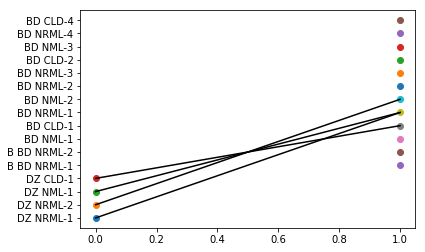

In [31]:
for i in dz:
    plt.plot(0, i, "o")
for j in break_down_zones:
    plt.plot(1, j, "o")
for i in dz:
    for j in break_down_zones:
        if(x[i,j].x>0.5):
            plt.plot([0,1], [i,j], "k")# todo
            
plt.show()

In [32]:
booking.columns

Index(['Shipment ID', 'FlightDate', 'ShipmentArrivalDateUTC', 'ProductName',
       'ShipmentOrigin', 'ShipmentDestination', 'CarrierCode', 'Priority',
       'DropZone', 'FlightNumberArrival', 'SerialNumber', 'ArrivalULDNumber',
       'Pieces', 'Weight', 'Volume', 'BookingStatus', 'WeighCMMit',
       'VolumeUnit', 'TotalVolume', 'TotalWeight', 'TotalNumberOfPieces',
       'FlightNumberDeparture', 'ShipmentDepartureDateUTC'],
      dtype='object')

In [35]:
booking['ShipmentArrivalDateUTC'].dtype

dtype('O')

In [39]:
booking['Shipment_arrival_date_time'] = pd.to_datetime(booking['ShipmentArrivalDateUTC'])

In [42]:
booking.head()

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,Volume,BookingStatus,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,Shipment_arrival_date_time
0,020-77215633,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ACC,ZZ,False,DZ NRML-2,1,...,0.08,C,K,B,0.08,26.2,1,3,2018-10-25T05:15:00,2018-10-23 06:10:00
1,020-77215515,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ADD,ZZ,False,DZ NRML-2,1,...,0.02,C,K,B,0.02,5.5,1,4,2018-10-27T13:45:00,2018-10-23 06:10:00
2,020-84100306,2018-10-23,2018-10-23T06:10:00,NML,BBB,AGG,ZZ,False,DZ NML-1,1,...,0.01,C,K,B,0.01,2.6,1,7,2018-10-24T21:20:00,2018-10-23 06:10:00
3,020-82036091,2018-10-23,2018-10-23T06:10:00,NRML,BBB,AII,ZZ,False,DZ NRML-2,1,...,0.01,C,K,B,0.01,1.7,1,9,2018-10-27T17:20:00,2018-10-23 06:10:00
4,020-84368815,2018-10-23,2018-10-23T06:10:00,NRML,BBB,CCC,ZZ,False,DZ NRML-2,1,...,0.26,C,K,B,0.26,22.6,1,46,2018-10-24T23:00:00,2018-10-23 06:10:00


In [63]:
pd.to_datetime(booking['ShipmentArrivalDateUTC'])

0     2018-10-23 06:10:00
1     2018-10-23 06:10:00
2     2018-10-23 06:10:00
3     2018-10-23 06:10:00
4     2018-10-23 06:10:00
5     2018-10-23 06:10:00
6     2018-10-23 06:10:00
7     2018-10-23 06:10:00
8     2018-10-23 06:10:00
9     2018-10-23 06:10:00
10    2018-10-23 06:10:00
11    2018-10-23 06:10:00
12    2018-10-23 06:10:00
13    2018-10-23 06:10:00
14    2018-10-23 06:10:00
15    2018-10-23 06:10:00
16    2018-10-23 06:10:00
17    2018-10-23 06:10:00
18    2018-10-23 06:10:00
19    2018-10-23 06:10:00
20    2018-10-23 06:10:00
21    2018-10-23 06:10:00
22    2018-10-23 06:10:00
23    2018-10-23 06:10:00
24    2018-10-23 06:10:00
25    2018-10-23 06:10:00
26    2018-10-23 06:10:00
27    2018-10-23 06:10:00
28    2018-10-23 06:10:00
29    2018-10-23 06:10:00
              ...        
755   2018-10-27 01:45:00
756   2018-10-27 01:45:00
757   2018-10-27 01:45:00
758   2018-10-27 01:45:00
759   2018-10-25 01:45:00
760   2018-10-25 01:45:00
761   2018-10-24 04:30:00
762   2018-1

In [47]:
booking['ShipmentDepartureDateUTC'].dtype

dtype('O')

In [ ]:
#booking['ShipmentDepartureDateUTC'].str.replace('T',' ')

In [56]:
booking['ShipmentDepartureDateUTC'].unique()

array(['2018-10-25T05:15:00', '2018-10-27T13:45:00',
       '2018-10-24T21:20:00', '2018-10-27T17:20:00',
       '2018-10-24T23:00:00', '2018-10-26T06:45:00',
       '2018-10-25T13:30:00', '2018-10-24T23:30:00',
       '2018-10-26T19:10:00', '2018-10-27T08:30:00',
       '2018-10-25T18:20:00', '2018-10-27T14:50:00',
       '2018-10-24T19:05:00', '2018-10-25T14:05:00',
       '2018-10-26T18:55:00', '2018-10-25T22:30:00',
       '2018-10-25T02:00:00', '2018-10-25T16:35:00',
       '2018-10-25T23:15:00', '2018-10-23T19:10:00',
       '2018-10-24T20:10:00', '2018-10-24T20:25:00',
       '2018-10-26T01:30:00', '2018-10-26T14:20:00',
       '2018-10-25T13:45:00', '2018-10-24T05:00:00',
       '2018-10-25T02:50:00', '2018-10-25T02:20:00',
       '2018-10-25T05:00:00', '2018-10-26T10:45:00',
       '2018-10-25T11:10:00', '2018-10-25T21:20:00',
       '2018-10-25T11:30:00', '2018-10-25T06:00:00',
       '2018-10-30T05:00:00', '2018-10-24T18:45:00',
       '2018-10-25T20:55:00', '2018-10-25T06:3

In [57]:
booking = booking[booking.ShipmentDepartureDateUTC != '2018-10-24T26:20:00']

In [58]:
booking['Shipment_departure_date_time'] = pd.to_datetime(booking['ShipmentDepartureDateUTC'])

In [61]:
booking['Shipment_duration'] = booking['Shipment_departure_date_time']-booking['Shipment_arrival_date_time']

In [62]:
booking.head()

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration
0,020-77215633,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ACC,ZZ,False,DZ NRML-2,1,...,K,B,0.08,26.2,1,3,2018-10-25T05:15:00,2018-10-23 06:10:00,2018-10-25 05:15:00,1 days 23:05:00
1,020-77215515,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ADD,ZZ,False,DZ NRML-2,1,...,K,B,0.02,5.5,1,4,2018-10-27T13:45:00,2018-10-23 06:10:00,2018-10-27 13:45:00,4 days 07:35:00
2,020-84100306,2018-10-23,2018-10-23T06:10:00,NML,BBB,AGG,ZZ,False,DZ NML-1,1,...,K,B,0.01,2.6,1,7,2018-10-24T21:20:00,2018-10-23 06:10:00,2018-10-24 21:20:00,1 days 15:10:00
3,020-82036091,2018-10-23,2018-10-23T06:10:00,NRML,BBB,AII,ZZ,False,DZ NRML-2,1,...,K,B,0.01,1.7,1,9,2018-10-27T17:20:00,2018-10-23 06:10:00,2018-10-27 17:20:00,4 days 11:10:00
4,020-84368815,2018-10-23,2018-10-23T06:10:00,NRML,BBB,CCC,ZZ,False,DZ NRML-2,1,...,K,B,0.26,22.6,1,46,2018-10-24T23:00:00,2018-10-23 06:10:00,2018-10-24 23:00:00,1 days 16:50:00


In [67]:
booking[booking.Shipment_duration<pd.Timedelta(0)]

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration
53,020-88442185,2018-10-25,2018-10-25T06:35:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,2,...,K,B,0.32,23.5,3,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
54,020-88442196,2018-10-25,2018-10-25T06:35:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,2,...,K,B,0.44,43.7,4,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
55,020-88442200,2018-10-25,2018-10-25T06:35:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,2,...,K,B,0.12,9.6,2,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
56,020-86837940,2018-10-25,2018-10-25T06:35:00,NML,OOO,BBB,ZZ,False,DZ NML-1,2,...,K,B,0.60,39.5,18,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
59,020-83907692,2018-10-25,2018-10-25T11:05:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,12,...,K,B,0.20,9.5,2,25,2018-10-25T02:20:00,2018-10-25 11:05:00,2018-10-25 02:20:00,-1 days +15:15:00
426,020-84475440,2018-10-25,2018-10-25T13:10:00,NML,AUU,ABB,ZZ,False,DZ NML-1,438,...,K,B,1.62,84.1,12,2,2018-10-25T02:50:00,2018-10-25 13:10:00,2018-10-25 02:50:00,-1 days +13:40:00
